In [1]:
# TODO:

# load hallem data
# produce 100 iterations of S + q
# Compute true distance metrics
# implement distance bloom 
    # m=350
    # m=135
# implement fly bloom


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import os
T = np.transpose
# import hashlib # might need

In [10]:
# import hallem data
# os.chdir('/home/tsheehan/py_code/fly_dat/')
os.chdir('./fly_dat/')
dat = pd.read_csv("hallem1.txt",delimiter=' ')
# dat = T(dat.values) # universe 24,111
dat = dat.values
# dat = np.random.randn(150,111)
#dat = T(np.random.randn(100,111))


In [13]:
# Normalize data 
# shape dat - 111, 24

# dat_pos = dat - np.min(dat,axis = 0) # wrong, was z-scoring each trial, not each ORN
# dat_100 = dat_pos/np.mean(dat_pos,axis=0)*100 # d_in x n_ex
# dat_100 = (dat-np.mean(dat,axis=0))/np.std(dat,axis=0)
dat_100 = dat/np.mean(dat,axis=0)*100
#dat_z = (dat - np.mean(dat,axis=0))/np.std(dat,axis=0)

#print('z-scoring data')

# U = T(dat_100)
U = dat_100
# np.shape(dat_100)
# np.shape(dat)
# plt.hist(dat.flatten())
# plt.show()

In [14]:
# ORN space functions
def novelty_dist(S,q):
    cs = np.max([cor_sim(s,q) for s in S])
    return cs
#     return -(cs-1)
#     return 0.5*(1-cs)

def cos_sim(a,b):
    return np.dot(a,b)/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(a**2)))
def cor_sim(a,b):
    return np.dot(a-np.mean(a),b-np.mean(b))/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(a**2)))  

In [15]:
# np.shape(U) # 111 odors x 24 ORNs
n_ex = 1000
l_ex = 20
tag_ind = np.random.choice(111,(n_ex,l_ex),replace=True)
query_ind = np.random.choice(111,n_ex,replace=True)
S = U[tag_ind] # n_ex, l_ex, n_ORN
q = U[query_ind] # n_ex, n_ORN
N = [novelty_dist(S[i],q[i]) for i in range(n_ex)]

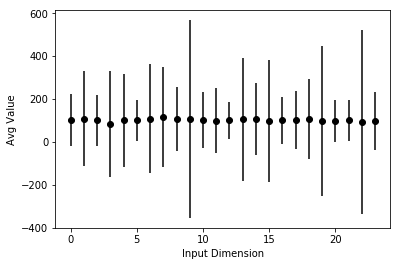

In [16]:
# what does the input data look like?
# np.shape(q) # n_ex, d_in
# plt.figure(figsize=(10,30))
# plt.imshow(T(q))
# plt.plot(np.mean(q,axis=0),'k.')
plt.errorbar(range(np.shape(q)[1]),np.mean(q,axis=0),np.std(q,axis=0),fmt='ko')
plt.xlabel('Input Dimension')
plt.ylabel('Avg Value')
plt.show()

# ?plt.errorbar

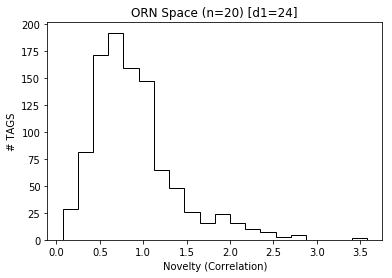

In [17]:
plt.hist(N,20,histtype='step',edgecolor='k')
plt.xlabel('Novelty (Correlation)')
plt.ylabel('# TAGS')
plt.title('ORN Space (n=%d) [d1=%d]' %(l_ex,np.shape(U)[1]))
plt.show()

In [29]:
# project S to m space
# os.chdir('~/py_code')
os.chdir('/Users/tim/py_code/')
from bloom_filters import * 

m = 350
k = 17

# m = 135
# k = 7

dIn = np.shape(S)[2]
M = np.random.randn(dIn,m)
Sm = np.matmul(S,M) # n_ex, l_ex, m
qm = np.matmul(q,M) # n_ex, m
Sm_hash = np.argpartition(Sm,-k)[:,:,-k:] # grab the k largest values
qm_hash = np.argpartition(qm,-k)[:,-k:]

Sm_tag = np.zeros(np.shape(Sm))
for i,ii in np.ndenumerate(Sm_hash):      # produce Boolean tags
    Sm_tag[i[0],i[1],ii] = 1   
    
qm_tag = np.zeros(np.shape(qm))
for i,ii in enumerate(qm_hash):
     qm_tag[i,ii] = 1

In [30]:
# projections complete √
# 1) Hamming distances full S √
# 2) Distance Bloom
# 3) Fly


# Bloom Filter Status

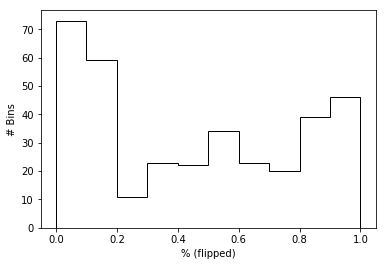

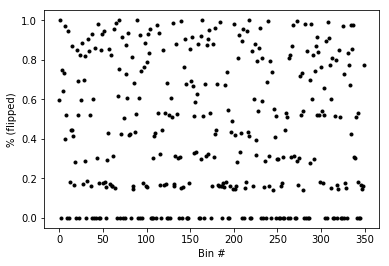

(1000, 20, 350)

In [31]:
# how spread out are the hashes?
Sm_bloom = np.sum(Sm_tag,axis=1)>0
avg_hash_loc = np.mean(Sm_bloom,axis=0)

plt.hist(avg_hash_loc,histtype='step',color='k')
plt.xlabel('% (flipped)')
plt.ylabel('# Bins')
plt.show()
plt.plot(avg_hash_loc,'k.')
plt.xlabel('Bin #')
plt.ylabel('% (flipped)')
plt.show()

np.shape(Sm_tag)
# np.mean(avg_hash_loc)
# 1-(1-1/350)**(k*l_ex)
# n_ex

In [32]:
# hamming distance S
# better is just sum of tag
def tag_cnt(S,q):
    return np.max([np.sum(s[q==1]) for s in S])
# N_tag = [-(tag_cnt(Sm_tag[i],qm_tag[i])/k-1) for i in range(n_ex)]      # Normalized
N_tag = [tag_cnt(Sm_tag[i],qm_tag[i])/k for i in range(n_ex)]       # not Normalized

# Hamming distance KC Space

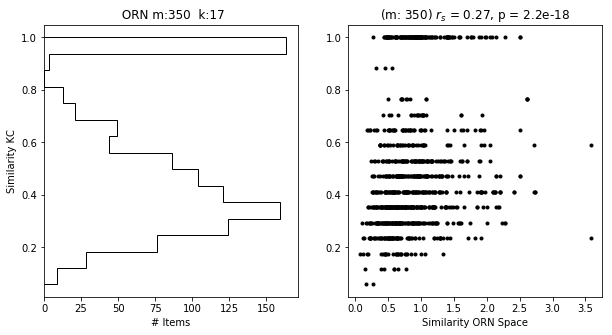

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(N_tag,15,histtype='step',color='k',orientation = 'horizontal')
# plt.xlabel('Minimum Hash Distance')
plt.title(' ORN m:%i  k:%i' %(m,k))
# plt.ylabel('Novelty ORN')
plt.ylabel('Similarity KC')
plt.xlabel('# Items')

plt.subplot(1,2,2)
#np.shape(N_tag) # 1000 #np.shape(N) # 1000
plt.plot(N,N_tag,'k.')
# plt.title('(m: %i) rho = %.2f, p = %.1e' %((m,) + pearsonr(N,N_tag)))
plt.title('(m: %i) $r_s$ = %.2f, p = %.1e' %((m,) + spearmanr(N,N_tag)))
# plt.xlabel('Novelty ORN Space')
plt.xlabel('Similarity ORN Space')
plt.show()


In [40]:
# Distance bloom
# compress Sm_tag and run that
Sm_bloom = np.sum(Sm_tag,axis=1)>0
Sm_count_bloom = np.sum(Sm_tag,axis=1)
# np.shape(Sm_bloom) # n_ex, m
# N_bloom = np.sum([Sm_bloom[i,np.where(qm_tag[i])[0]] for i in range(n_ex)],axis=1)/k
# N_bloom = np.sum(Sm_bloom[qm_hash],axis=1)/k
N_bloom = np.sum([Sm_bloom[i,qm_hash[i]] for i in range(n_ex)],axis=1)/k
# N_bloom = -(np.sum([Sm_bloom[i,np.where(qm_tag[i])[0]] for i in range(n_ex)],axis=1)/k-1) # Normalized
# N_bloom_count = -(np.sum([Sm_count_bloom[i,np.where(qm_tag[i])[0]] for i in range(n_ex)],axis=1)/k/l_ex-1)
N_bloom_count = np.sum([Sm_count_bloom[i,np.where(qm_tag[i])[0]] for i in range(n_ex)],axis=1)/k/l_ex
# np.shape(Sm_bloom) # n_ex, m
# np.shape(Sm_tag) # n_ex, l_ex, m
np.shape(N_bloom)

(1000,)

# Distnace Bloom Filter

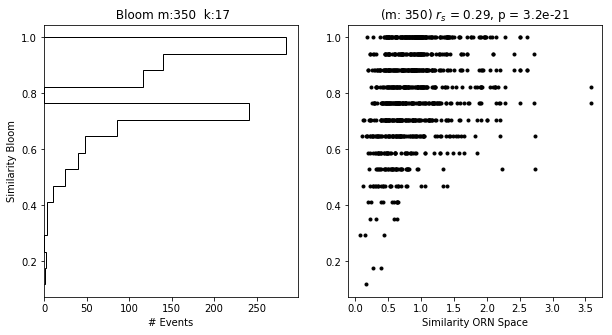

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(N_bloom,15,histtype='step',color='k',orientation = 'horizontal')
plt.title(' Bloom m:%i  k:%i' %(m,k))
# plt.ylabel('Novelty Bloom')
plt.ylabel('Similarity Bloom')
plt.xlabel('# Events')


plt.subplot(1,2,2)
plt.plot(N,N_bloom,'k.')
# plt.title('(m: %i) rho = %.2f, p = %.1e' %((m,) + pearsonr(N,N_bloom)))
plt.title('(m: %i) $r_s$ = %.2f, p = %.1e' %((m,) + spearmanr(N,N_bloom)))
# plt.xlabel('Novelty ORN Space')
plt.xlabel('Similarity ORN Space')
# plt.ylabel('Novelty Bloom')
plt.show()

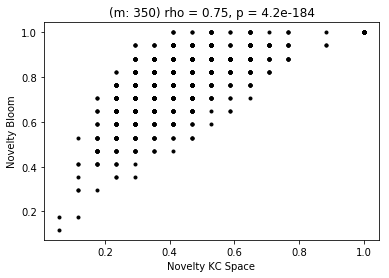

In [36]:
plt.plot(N_tag,N_bloom,'k.')
plt.title('(m: %i) rho = %.2f, p = %.1e' %((m,) + pearsonr(N_tag,N_bloom)))
plt.xlabel('Novelty KC Space')
plt.ylabel('Novelty Bloom')
plt.show()

# Distance Counting Bloom Filter

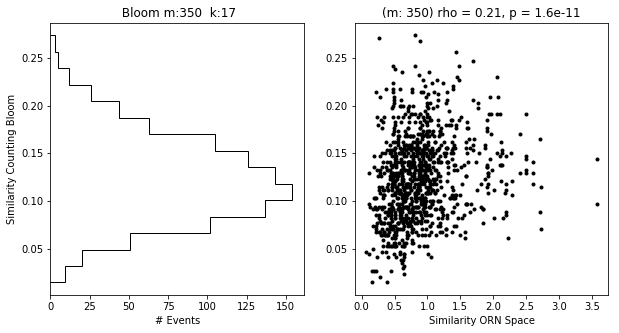

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(N_bloom_count,15,histtype='step',color='k',orientation = 'horizontal')
plt.title(' Bloom m:%i  k:%i' %(m,k))
# plt.ylabel('Novelty Counting Bloom')
plt.ylabel('Similarity Counting Bloom')
plt.xlabel('# Events')

plt.subplot(1,2,2)
plt.plot(N,N_bloom_count,'k.')
plt.title('(m: %i) rho = %.2f, p = %.1e' %((m,) + pearsonr(N,N_bloom_count)))
# plt.xlabel('Novelty ORN Space')
plt.xlabel('Similarity ORN Space')
# plt.ylabel('Novelty Counting Bloom')
plt.show()

# Fly Algorithm Implement
+ Will have timing sensitivity built in


In [55]:
# Fly ouput 
# np.shape(Sm_tag) # 1000, 20, 350
# np.shape(q) # 1000, 24
fly_out = np.zeros(n_ex)
for i in range(n_ex):
    fly_out[i] = fly_bloom(S=Sm_tag[i],q=qm_tag[i],rr=.01)
    

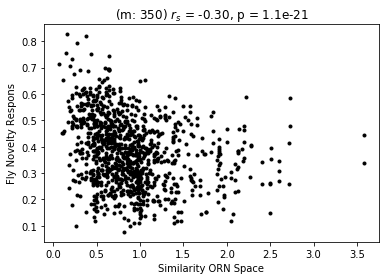

In [58]:
plt.plot(N,fly_out,'k.')
plt.title('(m: %i) $r_s$ = %.2f, p = %.1e' %((m,) + spearmanr(N,fly_out)))
# plt.xlabel('Novelty ORN Space')
plt.xlabel('Similarity ORN Space')
plt.ylabel('Fly Novelty Respons')
plt.show()